In [1]:
import cv2
import numpy as np
import os
import mediapipe as mp

from functools import partial
from matplotlib import pyplot as plt
import matplotlib.animation as animation

from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

from scipy import stats
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

from jproperties import Properties

In [2]:
configs = Properties()
with open('../.properties', 'rb') as config_file: configs.load(config_file)
CAMERA_INDEX = int(configs.get('CAMERA_INDEX').data)

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

In [4]:
def draw_styled_landmarks(image, results):
    mp.solutions.drawing_utils.draw_landmarks(image, results.pose_landmarks, mp.solutions.holistic.POSE_CONNECTIONS,
                             mp.solutions.drawing_utils.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp.solutions.drawing_utils.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2))

In [6]:
DESCRIPTOR_LEN = len(mp.solutions.holistic.PoseLandmark) * 4

def extract_descriptor(results):
    return np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(DESCRIPTOR_LEN)

In [7]:
def prob_viz(res, actions, frame):
    colors = [(245,117,16), (117,245,16), (16,117,245)]
    output_frame = frame.copy()
    for idx, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+idx*40), (int(prob*100), 90+idx*40), colors[idx], -1)
        cv2.putText(output_frame, actions[idx], (0, 85+idx*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [8]:
def draw_frame(frame_index, landmarks_list):
    plt.clf()
    body_landmarks = landmarks_list[frame_index]

    # Extract the x and y coordinates of the landmarks
    x = [lm.x for lm in body_landmarks.landmark]
    y = [lm.y for lm in body_landmarks.landmark]

    # Draw landmarks as points
    plt.scatter(x, y, s=20, c='blue')

    # Draw the connecting lines between the landmarks
    connections = [(11, 12), (12, 24), (24, 23), (23, 11),  # Head
                   (11, 13), (13, 15), (15, 17),  # Left Arm
                   (12, 14), (14, 16), (16, 18),  # Right Arm
                   (11, 25), (25, 23),  # Spine
                   (24, 26), (26, 28), (28, 30),  # Left Leg
                   (23, 27), (27, 29), (29, 31)]  # Right Leg

    for connection in connections:
        plt.plot([x[connection[0]], x[connection[1]]], [y[connection[0]], y[connection[1]]], c='blue')

    plt.axis('off')

    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.gca().invert_yaxis()

## Output directories

In [9]:
DATA_PATH = os.path.join('Dataset_atomic_gestures') 
actions = np.array(['hand-up', 'flex', 'idle'])
num_sequences = 10
sequence_length = 30

In [10]:
if not os.path.exists(DATA_PATH):
    os.mkdir(DATA_PATH)

for action in actions: 
    if not os.path.exists(os.path.join(DATA_PATH, action)):
        os.mkdir(os.path.join(DATA_PATH, action))

for action in actions: 
    for sequence in range(num_sequences):
        os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))

In [11]:
def create_gif(landmarks_list, action):
    fig = plt.figure()
    ani = animation.FuncAnimation(fig, partial(draw_frame, landmarks_list=landmarks_list), frames=len(landmarks_list), interval=100)
    output_gif = os.path.join(DATA_PATH, action, f'{action}.gif')
    ani.save(output_gif, writer='imagemagick', fps=10)
    if os.path.exists(output_gif):
        return True
    else:
        return False

MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


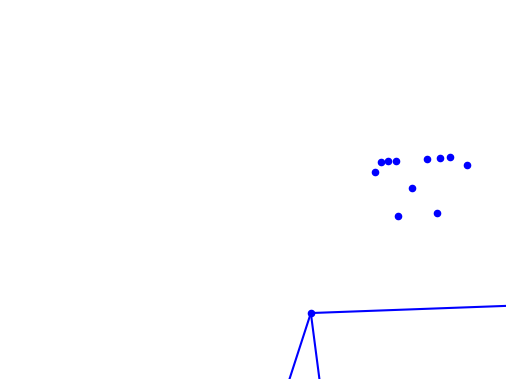

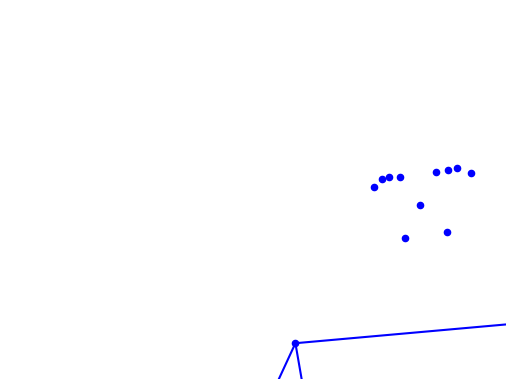

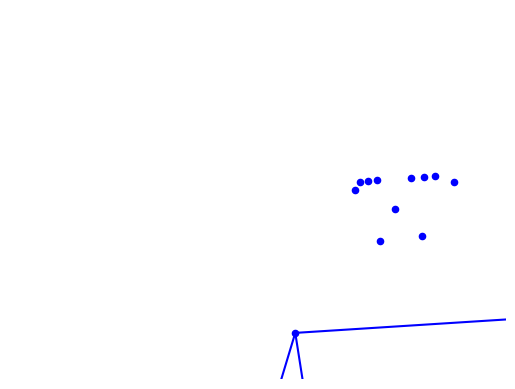

In [12]:
cap = cv2.VideoCapture(CAMERA_INDEX)
with mp.solutions.holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    for action in actions:
        # Flag to check if the GIF has been created for this action
        gif_created = False
        landmarks_list = []
        for sequence in range(num_sequences):
            for frame_num in range(sequence_length):
                ret, frame = cap.read()
                image, results = mediapipe_detection(frame, holistic)

                # Extract body landmarks and append them to the list
                if not gif_created:
                    body_landmarks = results.pose_landmarks
                    if body_landmarks:
                        landmarks_list.append(body_landmarks)

                draw_styled_landmarks(image, results)
                
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, f'Action: {action}. Video #{sequence}', (15,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(2000)
                else: 
                    cv2.putText(image, f'Action: {action}. Video #{sequence}', (15,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    cv2.imshow('OpenCV Feed', image)
                
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                keypoints = extract_descriptor(results)
                np.save(npy_path, keypoints)

                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break

            # Creation of the .gif
            if not gif_created and landmarks_list:
                gif_created = create_gif(landmarks_list, action)             

    cap.release()
    cv2.destroyAllWindows()

## Build and Train LSTM Neural Network

In [ ]:
label_map = {label:num for num, label in enumerate(actions)}
sequences, labels = [], []

for action in actions:
    for sequence in range(num_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), f"{frame_num}.npy"))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [ ]:
X = np.array(sequences)
y = to_categorical(labels).astype(int) # one hot encoding
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [ ]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(sequence_length, DESCRIPTOR_LEN)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [ ]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback])

In [ ]:
model.summary()

## Evaluation using Confusion Matrix and Accuracy

In [ ]:
yhat = model.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [ ]:
multilabel_confusion_matrix(ytrue, yhat)

In [ ]:
accuracy_score(ytrue, yhat)

## Test in Real Time

In [ ]:
sequence = []
sentence = []
predictions = []

num_frames_for_stability = 10
threshold = 0.5

cap = cv2.VideoCapture(CAMERA_INDEX)

with mp.solutions.holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()
        image, results = mediapipe_detection(frame, holistic)
        
        draw_styled_landmarks(image, results)
        
        keypoints = extract_descriptor(results)
        sequence.append(keypoints)
        sequence = sequence[-sequence_length:]
        
        if len(sequence) == sequence_length:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            predictions.append(np.argmax(res))
             
            is_stable_prediction = np.unique(predictions[-num_frames_for_stability:])[0]==np.argmax(res)
            if is_stable_prediction: 
                if res[np.argmax(res)] > threshold:            
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: sentence = sentence[-5:]

            image = prob_viz(res, actions, image)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        cv2.imshow('OpenCV Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()